# Analysis of Facebook Behaviour.
After downloading my personal facebook data from the past ~10 years, ive decided to run my own analysis on it.
To understand my behavioural pattern better ive focused mostly on:
* Reactions and activity during days/months
* Comments, comment frequency and tendency

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os
from datetime import datetime as dt

# Importing configparser for managing files and settings
import configparser as cp

# Importing warnings and turning off deprecation warnings to clear the field of view a bit.
import warnings

warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

%matplotlib inline

In [2]:
# Establishing a config file and extracting the relevant information within

config = cp.ConfigParser()
config.read("config.ini")
DATA = config.get("links", "DATA")

In [3]:
# Accessing the relevant folders withhin the unzipped file

catalogue = os.listdir(DATA)
activity = os.listdir(DATA+"\\your_facebook_activity")
comments = os.listdir(DATA+"\\your_facebook_activity\\comments_and_reactions")
messages = os.listdir(DATA+"\\your_facebook_activity\\messages")

In [4]:
# Entering the respective Subfolder

for root,_,_ in os.walk(DATA):
    if "comments" in root:
        os.chdir(root)

# Preprocessing of the Dataframe for further analysis

In [6]:
times = []
reacts = []
action = []
actor = []

In [7]:
# Filtering for the relevant columns in the comments folder,
# excluding comment-content and most active days

for i in comments[1:-1]:
    data_path = os.getcwd()+"\\"+i
    file = open(data_path)
    file_open = json.load(file)

    for i in range(len(file_open)):
        times.append(dt.utcfromtimestamp(file_open[i]["timestamp"]))
        reacts.append(file_open[i]["data"][0]["reaction"]["reaction"])
        actor.append(file_open[i]["data"][0]["reaction"]["actor"])
        action.append(file_open[i]["title"])

In [8]:
# Creating the DataFrame for further processing.

comments_df = pd.DataFrame({"times":times, "reactions":reacts, "actor":actor, "actions":action})

In [9]:
# Segmenting times column into its parts.

comments_df["year"] = comments_df["times"].dt.year
comments_df["month"] = comments_df["times"].dt.month
comments_df["day"] = comments_df["times"].dt.day
comments_df["hour"] = comments_df["times"].dt.hour
comments_df["minute"] = comments_df["times"].dt.minute
comments_df["second"] = comments_df["times"].dt.second

In [37]:
comments_df[["times","reactions","actor","year","month","day","hour","minute","second"]].head()

,times,reactions,actor,year,month,day,hour,minute,second
0,2012-10-10 20:28:08,LIKE,Sergej Nikitin,2012,10,10,20,28,8
1,2012-10-10 20:28:15,LIKE,Sergej Nikitin,2012,10,10,20,28,15
2,2012-10-19 19:39:06,LIKE,Sergej Nikitin,2012,10,19,19,39,6
3,2012-10-26 11:11:23,LIKE,Sergej Nikitin,2012,10,26,11,11,23
4,2012-10-30 20:24:45,LIKE,Sergej Nikitin,2012,10,30,20,24,45


# Exploration

In [12]:
from sklearn.preprocessing import OneHotEncoder
OHE = OneHotEncoder(sparse=False)

<Axes: xlabel='None', ylabel='month'>

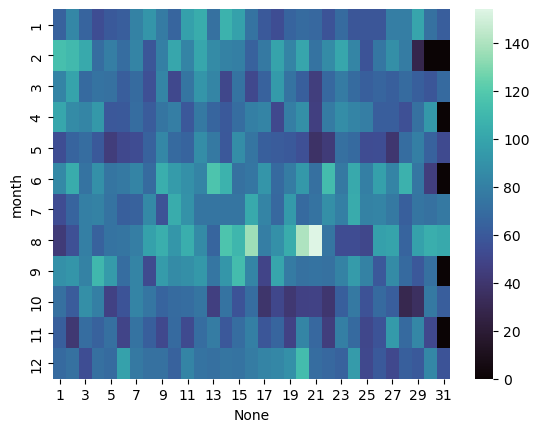

In [13]:
# Creating Sub-DataFrame for months and days and applying OneHotEncoder.
# Exploring the activity over each day of each month,
# to look for potential patterns.

months_days_df = comments_df[["month", "day"]]
months_days_df.set_index("month", inplace=True)

OHE_months_days = OHE.fit_transform(months_days_df)
OHE_months_days_df = pd.DataFrame(OHE_months_days, columns=OHE.categories_)

OHE_months_days_df.set_index(months_days_df.index, inplace=True)
OHE_months_days_df = OHE_months_days_df.groupby("month").sum()

sns.heatmap(OHE_months_days_df, cmap="mako")

<Axes: xlabel='None', ylabel='hour'>

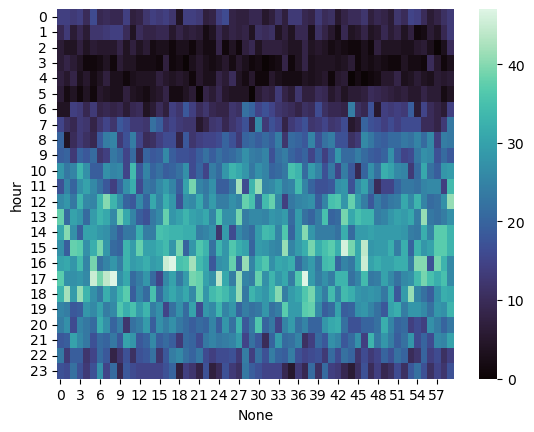

In [14]:
# Repeating the above procedure for hours and minutes of a day,
# showing obvious activity during day times and limited activity during the night.

hours_minutes_df = comments_df[["hour", "minute"]]
hours_minutes_df.set_index("hour", inplace=True)

OHE_hours_minutes = OHE.fit_transform(hours_minutes_df)
OHE_hours_minutes_df = pd.DataFrame(OHE_hours_minutes, columns=OHE.categories_)

OHE_hours_minutes_df.set_index(hours_minutes_df.index, inplace=True)
OHE_hours_minutes_df = OHE_hours_minutes_df.groupby("hour").sum()

sns.heatmap(OHE_hours_minutes_df, cmap="mako")

In [15]:
for root,_,_ in os.walk(DATA+"\\your_facebook_activity"):
    if root.endswith("\messages"):
        os.chdir(root)

In [16]:
participants = []
times = []
sender_name = []
content = []

In [17]:
# Filtering for the relevant columns in the messages folder,
# excluding old group conversations (not community chats however)

for i in messages:
    if i == "inbox":
        inbox_data_path = os.getcwd()+"\\"+i
        for i2 in os.listdir(inbox_data_path)[:37]:
            
            # Since old group conversations are saved in folders that are purely numerical
            # and individual messages and community chats begin with letters, we filter here.
            
            if str.isalpha(i2[0]):
                sub_data_path = inbox_data_path+"\\"+i2
                messages = [x for x in os.listdir(sub_data_path) if "message" in x]
                sub_data_path += f"\\{messages[0]}"
                
                file = open(sub_data_path)
                file_open = json.load(file)

                print(file_open["participants"], file_open["messages"])

[{'name': 'Aarklash: Legacy'}, {'name': 'Sergej Nikitin'}] [{'sender_name': 'Sergej Nikitin', 'timestamp_ms': 1374503596745, 'content': 'suppenhuhn007@gmx.de\n\ni suppose youve got already several hundreds of people but still, heres my email, itd like to join :D', 'is_geoblocked_for_viewer': False}]
[{'name': 'Aaron Bomeke'}, {'name': 'Sergej Nikitin'}] [{'sender_name': 'Sergej Nikitin', 'timestamp_ms': 1554209775998, 'content': 'Ihr seid jetzt im Messenger miteinander verbunden', 'is_geoblocked_for_viewer': False}]
